In [284]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import os
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from numpy import linalg
# from google.colab import drive

In [285]:
def mean(Xtrain):
    return np.mean(Xtrain, axis = 1)

In [286]:
def X(Xtrain, mean):
    Xdef = []
    for col in Xtrain.T:
        Xdef.append(col - mean)
    Xdef = np.array(Xdef)
    return Xdef.T

In [287]:
def covMat(X):
    C1 = np.dot(X, X.T)
    return C1

In [288]:
def eigenVectors(X, C):
    eigVal1, eigVect1 = linalg.eig(C)
    return eigVect1

In [289]:
def eigenWeights(E, X):
    weights = np.matmul(E.T, X)
    return weights

In [290]:
def face_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade_image = cv2.CascadeClassifier('FaceDetHaarXML/haarcascade_frontalface_alt2.xml')
    faces = cascade_image.detectMultiScale(image, scaleFactor = 1.3, minNeighbors = 5)
    if (len(faces) == 0):
        return None, None
    (x, y, l, b) = faces[0]
    return image[y:y+b, x:x+l], faces[0]

def oval(img):
    gray = cv2.cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('FaceDetHaarXML/haarcascade_frontalface_alt.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    face_x =0
    face_y =0
    final_img = None
    for (x,y,w,h) in faces:
        face_x = x
        face_y = y
        roi_gray = gray[y:y+h, x:x+w]
        roi_color =img[y:y+h, x:x+w]
        mask = np.zeros_like(roi_color)
        rows, cols,_ = mask.shape
        mask=cv2.ellipse(mask,(int(rows/2), int(cols/2)), (250,300), angle=0, startAngle=0, endAngle=360, color=(255,255,255), thickness=-1)
        
        oval = np.bitwise_and(roi_color,mask)
        final_img=np.zeros_like(img)
        final_img[y:y+h, x:x+w]= oval
        final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
    return final_img

In [291]:
def loadDataLabels(data_path):
    faces = []
    labels = []
    enc_labels = []
    directories = os.listdir(data_path)
    for i, direc in enumerate(directories):
        sub_dir_path = data_path + "/" + direc
        sub_dir_images = os.listdir(sub_dir_path)
        label = direc
        for j, image_name in enumerate(sub_dir_images):
            image_path = sub_dir_path + "/" + image_name
            img = cv2.imread(image_path)
#             image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            face_detected, shape = face_detection(img)
#             face_detected = oval(img)
#             face_detected = cv2.cvtColor(face_detected, cv2.COLOR_RGB2GRAY)
            if face_detected is not None:
                face_detected = cv2.resize(face_detected, (64, 64))
                faces.append(face_detected)
                labels.append(label)
    labels = np.array(labels)
    label_encoder = preprocessing.LabelEncoder()
    enc_labels = label_encoder.fit_transform(labels) 
    labels_unique = label_encoder.classes_
    faces = np.array(faces)
    labels_unique = np.array(labels_unique)
    enc_labels = np.array(enc_labels)
    return faces, labels, labels_unique, enc_labels

In [292]:
def weightMatrix(X_data):
    print ('X_data shape: ', X_data.shape)
    mean_ = mean(X_data)
    print ('mean shape: ', mean_.shape)
    X_ = X(X_data, mean_)
    print ('X shape: ', X_.shape)
    C = covMat(X_)
    print ('C shape: ', C.shape)
    E = eigenVectors(X_, C)
    print ('E shape: ', E.shape)
    weightMatrix = np.matmul(E.T, X_data)
    print ('wtMat shape: ', weightMatrix.shape)
    return E, weightMatrix

In [293]:
def flattenData(X):
    X_data = []
    for image in X:
        X_data.append(image.flatten())
    X_data = np.array(X_data)
    return X_data.T

In [294]:
def PCAfamilyCoeff(X_train):
    X_data = flattenData(X_train)
    eigenVect, eigenCoeff = weightMatrix(X_data)
    return eigenVect, eigenCoeff

def PCAfamilyEigen(X_data):
    X_data = flattenData(X_data)
    mean_ = mean(X_data)
    print ('mean shape: ', mean_.shape)
    X_ = X(X_data, mean_)
    print ('X shape: ', X_.shape)
    C = covMat(X_)
    print ('C shape: ', C.shape)
    E = eigenVectors(X_, C)
    print ('E shape: ', E.shape)
    return E

In [313]:
def drawEigenFaces(eigenVect, index):
    eigenFace = np.real(eigenVect)
    eigenFace = ((eigenFace.T)[index]).reshape(64, 64)
    print(eigenFace)
    plt.imshow(eigenFace, cmap = 'jet')
    plt.show()

In [296]:
def euclideanDistance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [356]:
def leastEucDist(matrix, vector):
    min_ind = 1000000
    min_ed = 1000000
    for i in range(((matrix.T).shape)[0]):
        euc_dist = euclideanDistance(vector, (matrix.T)[i]) 
        if(euc_dist < min_ed):
            min_ed = euc_dist
            min_ind = i
    return min_ind

def leastEucDistN(matrix, vector, N):
    min_ind = 1000000
    min_ed = 1000000
    l = []
    for i in range(((matrix.T).shape)[0]):
        euc_dist = euclideanDistance(vector, (matrix.T)[i]) 
        l.append([euc_dist, i])
    l = sorted(l)
    min_ind_list = []
    for i in range(N):
        min_ind_list.append(l[i][1])
#     print (min_ind_list)
    return min_ind_list

In [374]:
def PCA_prediction(X_train, y_train, X_test, E):
#     train_eigenVect, train_eigenCoeff = PCAfamilyCoeff(X_train)
#     test_eigenVect, test_eigenCoeff = PCAfamilyCoeff(X_test)
    eigenVect_train = E
    X_train = flattenData(X_train)
    X_test = flattenData(X_test)
    print('X_train: ', X_train.shape)
    train_eigenCoeff = eigenWeights(eigenVect_train, X_train)
    print('Eigen Coeff train shape: ', train_eigenCoeff.shape)
    test_eigenCoeff = eigenWeights(eigenVect_train, X_test)
    print('Eigen Coeff test shape: ', test_eigenCoeff.shape)
    predictions = []
    for test_col in test_eigenCoeff.T:
        predictions.append(y_train[leastEucDist(train_eigenCoeff, test_col)])
    return predictions

def PCA_predictionN(X_train, y_train, X_test, E, N):
#     train_eigenVect, train_eigenCoeff = PCAfamilyCoeff(X_train)
#     test_eigenVect, test_eigenCoeff = PCAfamilyCoeff(X_test)
    eigenVect_train = E
    X_train = flattenData(X_train)
    X_test = flattenData(X_test)
#     print('X_train: ', X_train.shape)
    train_eigenCoeff = eigenWeights(eigenVect_train, X_train)
#     print('Eigen Coeff train shape: ', train_eigenCoeff.shape)
    test_eigenCoeff = eigenWeights(eigenVect_train, X_test)
#     print('Eigen Coeff test shape: ', test_eigenCoeff.shape)
    predictions = []
    for test_col in test_eigenCoeff.T:
        l1 = leastEucDistN(train_eigenCoeff, test_col, N)
        l2 = []
        for i in range(len(l1)):
            l2.append(y_train[l1[i]])
        predictions.append(l2)
    return predictions

In [376]:
def PCA_accuracy(predictions, y_test):
    count = 0
    len_y_test = len(y_test)
    if (len(predictions) != len(y_test)):
        print("Error...Mismatch in Lenghts!")
    len_y_test = len_y_test - 1
    for i in range(len(predictions)):
        if (predictions[i] == y_test[i]):
            count += 1
    print("PCA implementation Accuracy: ", (count/len_y_test)*100)

def PCA_accuracyN(predictions, y_test, N):
    count = 0
    len_y_test = len(y_test)
    if (len(predictions) != len(y_test)):
        print("Error...Mismatch in Lenghts!")
    len_y_test = len_y_test - 1
    for i in range(len(y_test)):
        if ((y_test[i]) in predictions[i]):
            count += 1
    print("PCA implementation top-", N, "Accuracy: ", (count/len_y_test)*100)

In [361]:
def Example(index, predictions, y_test, unique_labels):
    plt.imshow(X_test[index], cmap = 'gray')
    plt.show()
    print("Prediction made by Model: ", unique_labels[predictions[index]])
    print("Ground Truth: ", unique_labels[y_test[index]])

In [301]:
faces, labels, unique_labels, enc_labels = loadDataLabels("./Dataset")
(X_train, X_test, y_train, y_test) = train_test_split(faces, enc_labels, test_size = 0.25, random_state = 42)

In [302]:
eigenVect = PCAfamilyEigen(X_train)

mean shape:  (4096,)
X shape:  (4096, 436)
C shape:  (4096, 4096)
E shape:  (4096, 4096)


[[0.02871573 0.02343776 0.02310638 ... 0.02864247 0.02867449 0.03126216]
 [0.02532669 0.01933042 0.0160472  ... 0.02841387 0.02850081 0.03293257]
 [0.02134405 0.01592975 0.01395194 ... 0.0261762  0.03129166 0.03469948]
 ...
 [0.02131094 0.02229285 0.02187582 ... 0.03411163 0.03401644 0.03261166]
 [0.02179704 0.02268137 0.02381395 ... 0.03444198 0.0313317  0.0338204 ]
 [0.02484565 0.02523056 0.02254684 ... 0.03289894 0.03122523 0.03344911]]


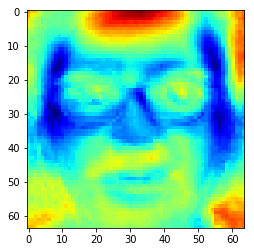

In [327]:
drawEigenFaces(eigenVect, 6)

In [304]:
predictions = PCA_prediction(X_train, y_train, X_test, eigenVect)

X_train:  (4096, 436)
Eigen Coeff train shape:  (4096, 436)
Eigen Coeff test shape:  (4096, 146)


In [305]:
# print(predictions)
# print(y_test)

PCA implementation Accuracy:  70.34482758620689


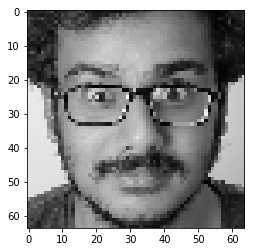

Prediction made by Model:  Vivek
Ground Truth:  Vivek


In [331]:
PCA_accuracy(predictions, y_test)
Example(100, predictions, y_test, unique_labels)

In [377]:
predictions_top1 = PCA_predictionN(X_train, y_train, X_test, eigenVect, 1)
PCA_accuracyN(predictions_top1, y_test, 1)
predictions_top3 = PCA_predictionN(X_train, y_train, X_test, eigenVect, 3)
PCA_accuracyN(predictions_top3, y_test, 3)
predictions_top10 = PCA_predictionN(X_train, y_train, X_test, eigenVect, 10)
PCA_accuracyN(predictions_top10, y_test, 10)

PCA implementation top- 1 Accuracy:  70.34482758620689
PCA implementation top- 3 Accuracy:  75.86206896551724
PCA implementation top- 10 Accuracy:  85.51724137931035
